Taken from
https://www.datascience.com/blog/introduction-to-bayesian-inference-learn-data-science-tutorials

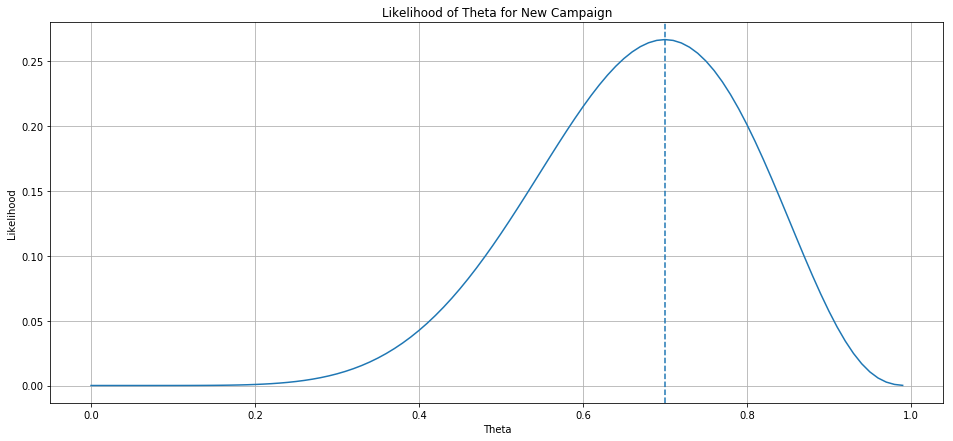

In [19]:
import numpy as np
from scipy.special import factorial
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (16,7)


def likelihood(theta, n, x):
    """
    likelihood function for a binomial distribution

    n: [int] the number of experiments
    x: [int] the number of successes
    theta: [float] the proposed probability of success
    """
    return (factorial(n) / (factorial(x) * factorial(n - x))) \
            * (theta ** x) * ((1 - theta) ** (n - x))

#the number of impressions for our facebook-yellow-dress campaign
n_impressions = 10.

#the number of clicks for our facebook-yellow-dress campaign
n_clicks = 7.
#observed click through rate
ctr = n_clicks / n_impressions
#0 to 1, all possible click through rates
possible_theta_values = list(map(lambda x: x/100., range(100)))

#evaluate the likelihood function for possible click through rates
likelihoods = list(map(lambda theta: likelihood(theta, n_impressions, n_clicks)\
                                , possible_theta_values))

#pick the best theta
mle = possible_theta_values[np.argmax(likelihoods)]
#plot
f, ax = plt.subplots(1)
ax.plot(possible_theta_values, likelihoods)
ax.axvline(mle, linestyle = "--")
ax.set_xlabel("Theta")
ax.set_ylabel("Likelihood")
ax.grid()
ax.set_title("Likelihood of Theta for New Campaign")
plt.show()

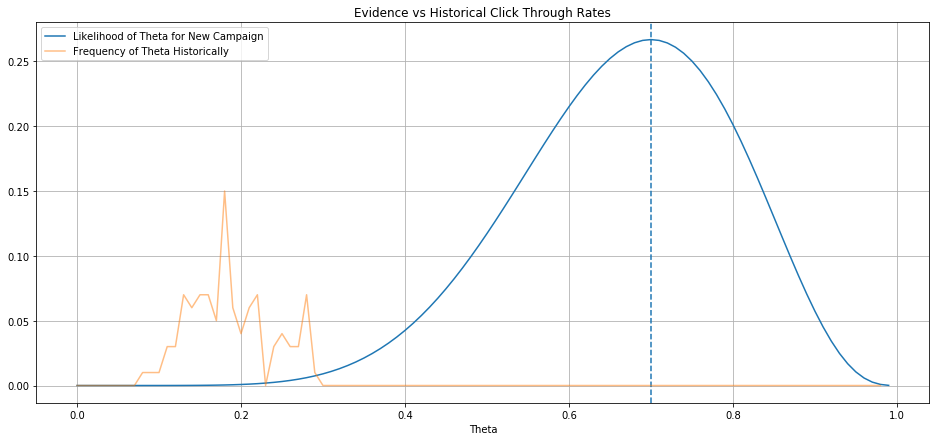

In [20]:
plt.rcParams['figure.figsize'] = (16, 7)
import numpy as np
import pandas as pd

true_a = 11.5
true_b = 48.5
#number of marketing campaigns
N = 100#randomly generate "true" click through rate for each campaign
p = np.random.beta(true_a,true_b, size=N)
#randomly pick the number of impressions for each campaign
impressions = np.random.randint(1, 10000, size=N)
#sample number of clicks for each campaign
clicks = np.random.binomial(impressions, p).astype(float)
click_through_rates = clicks / impressions
#plot the histogram of previous click through rates with the evidence#of the new campaign
f, ax = plt.subplots(1)
ax.axvline(mle, linestyle = "--")
ax.plot(possible_theta_values, likelihoods)

zero_to_one = [j/100. for j in range(100)]
counts, bins = np.histogram(click_through_rates
                            , bins=zero_to_one)
counts = counts / 100.
ax.plot(bins[:-1],counts, alpha = .5)
line1, line2, line3 = ax.lines
ax.legend((line2, line3), ('Likelihood of Theta for New Campaign'
                           , 'Frequency of Theta Historically')
                          , loc = 'upper left')
ax.set_xlabel("Theta")
ax.grid()
ax.set_title("Evidence vs Historical Click Through Rates")
plt.show()

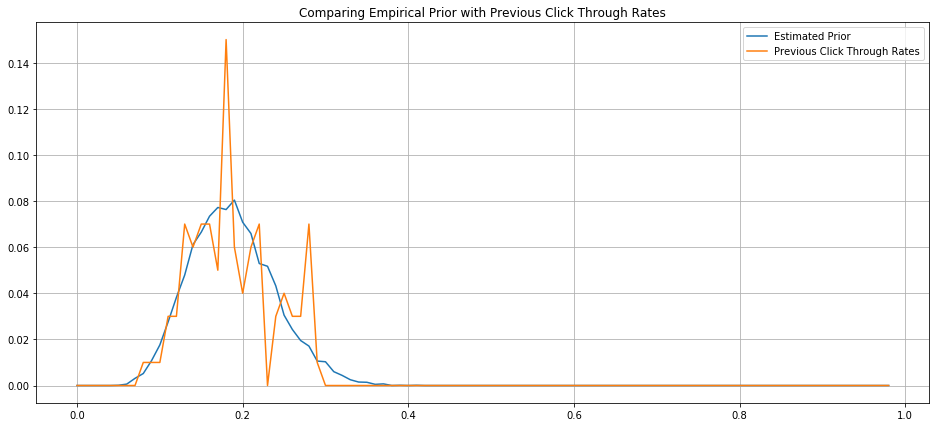

In [21]:
from scipy.stats import beta
#fit beta to previous CTRs
prior_parameters = beta.fit(click_through_rates
                            , floc = 0
                            , fscale = 1)  # extract a,b from fit
prior_a, prior_b = prior_parameters[0:2]

#define prior distribution sample from prior
prior_distribution = beta(prior_a, prior_b)
#get histogram of samples
prior_samples = prior_distribution.rvs(10000)
#get histogram of samples
fit_counts, bins = np.histogram(prior_samples
                                , zero_to_one)   #normalize histogram
fit_counts = list(map(lambda x: float(x)/fit_counts.sum()
                         , fit_counts))
#plot
f, ax = plt.subplots(1)
ax.plot(bins[:-1], fit_counts)

hist_ctr, bins = np.histogram(click_through_rates
                              , zero_to_one)
hist_ctr = list(map(lambda x: float(x)/hist_ctr.sum()
                              , hist_ctr))
ax.plot(bins[:-1], hist_ctr)
estimated_prior, previous_click_through_rates = ax.lines
ax.legend((estimated_prior, previous_click_through_rates)
          ,('Estimated Prior'
            , 'Previous Click Through Rates'))
ax.grid()
ax.set_title("Comparing Empirical Prior with Previous Click Through Rates")
plt.show()

In [22]:
import pymc3 as pm
import numpy as np

#create our data:clicks = np.array([n_clicks])
#clicks represents our successes. We observed 7 clicks.impressions = np.array([n_impressions])
#this represents the number of trials. There were 10 impressions.

with pm.Model() as model:
#sets a context; all code in block "belongs" to the model object

    theta_prior = pm.Beta('prior', 11.5, 48.5)
    #our prior distribution, Beta (11.5, 48.5)
    observations = pm.Binomial('obs',n = impressions
                               , p = theta_prior
                               , observed = clicks)     #Sampling distribition of outcomes in the dataset.
    #our prior p_prior will be updated with data


    start = pm.find_MAP()    #find good starting values for the sampling algorithm
    #Max Aposterior values, or values that are most likely

    step = pm.NUTS(state=start)     #Choose a particular MCMC algorithm     #we'll choose NUTS, the No U-Turn Sampler (Hamiltonian)

    trace = pm.sample(5000
                      , step
                      , start=start
                      , progressbar=True)               #obtain samples

/Users/furnstah/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
logp = -4,248, ||grad|| = 591.32: 100%|██████████| 6/6 [00:00<00:00, 654.32it/s]


TypeError: function() got an unexpected keyword argument 'state'

In [ ]:
#plot the histogram of click through rates
plt.rcParams['figure.figsize'] = (16, 7)
#get histogram of samples from posterior distribution of CTRs
posterior_counts, posterior_bins = np.histogram(trace['prior']
                                                ,bins=zero_to_one)
#normalized histogramposterior_counts = posterior_counts / float(posterior_counts.sum())
#take the mean of the samples as most plausible value
most_plausible_theta = np.mean(trace['prior'])
#histogram of samples from prior distribution
prior_counts, bins = np.histogram(prior_samples
                                  , zero_to_one)#normalize
prior_counts = map(lambda x: float(x)/prior_counts.sum()
                   , prior_counts)
#plot
f, ax = plt.subplots(1)
ax.plot(possible_theta_values, likelihoods)
ax.plot(bins[:-1],prior_counts, alpha = .2)
ax.plot(bins[:-1],posterior_counts)
ax.axvline(most_plausible_theta, linestyle = "--", alpha = .2)
line1, line2, line3, line4 = ax.lines
ax.legend((line1, line2, line3, line4), ('Evidence'
                                         , 'Prior Probability for Theta'
                                         , 'Posterior Probability for Theta'
                                         , 'Most Plausible Theta'
                                        ), loc = 'upper left')
ax.set_xlabel("Theta")
ax.grid()
ax.set_title("Prior Distribution Updated with Some Evidence")
plt.show()
 